<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Aprendizado

In [1]:
# # Instalar pt_BR
# !/usr/share/locales/install-language-pack pt_BR
# !dpkg-reconfigure locales

# import os

# # Reiniciar o Python
# os.kill(os.getpid(), 9)

# Importações

In [2]:
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

import datetime, locale, os, random

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Conv1D, Dense, Input, Lambda, Layer, Subtract
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from absl import logging as absl_logging

# Configurações

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

# locale.setlocale(locale.LC_ALL, 'pt_BR')

SEMENTE = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'
CORES  = ['#007F66', '#339966', '#66B266', '#99CC66', '#CCE566']

# COR_TREINO   = '#663399'
# COR_TESTE    = '#345cd3'
# COR_PREVISAO = '#f22424'

LINHA_ESPESSURA = 1

CAMINHO_MARCOS = 'marcos'

# Define o nível de log Abseil para 'ERROR'.
# https://abseil.io/docs/python/guides/logging
absl_logging.set_verbosity(absl_logging.ERROR)

## Funções

In [4]:
# https://stackoverflow.com/a/66343730

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEMENTE)

In [5]:
def avaliar_previsoes(alvos, previsoes):

    print(classification_report(alvos, previsoes))

    ConfusionMatrixDisplay.from_predictions(alvos, previsoes, values_format='d', cmap=PALETA)
    plt.grid(False)

    relatorio = classification_report(alvos, previsoes, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def obter_conjunto(dados_treino, dados_validacao, q_modelos=10):

    conjunto = []

    for m in range(q_modelos):

        print(f'Modelo {m} de {q_modelos}.')

        modelo = Sequential()

        [modelo.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
        modelo.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

        modelo.compile(loss=PERDA,
                       optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                       metrics=METRICAS)

        modelo.fit(dados_treino,
                   epochs=ITERACOES,
                   validation_data=dados_validacao,
                   verbose=0)
        
        conjunto.append(modelo)

    return conjunto

def obter_previsoes(conjunto, dados_validacao):
    
    previsoes = []

    for modelo in conjunto:
        previsoes.append(modelo.predict(dados_validacao, verbose=0))
    
    return tf.constant(tf.squeeze(previsoes))

def notificacoes_semanais(dados, local):

    ax = sns.lineplot(data=dados, x='Segunda-feira', y='Quantidade', linewidth=LINHA_ESPESSURA, color=CORES[0])

    plt.title(f'Notificações semanais {local}')
    plt.xlabel('')
    plt.ylabel('Quantidade de Notificações')

    plt.xlim([datetime.date(2020, 12, 25), datetime.date(2023, 3, 1)])

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    for tick in ax.get_xticklabels(which='both'):
        tick.set_rotation(90)

    plt.grid(visible=True, which='both', axis='both')
    plt.show()

def criar_janelas(dados, janela_tamanho, horizonte_tamanho, premios=[]):

    # Array 2D de 0 a janela_tamanho + horizonte_tamanho.
    janela_primaria = np.expand_dims(np.arange(janela_tamanho + horizonte_tamanho), axis=0)

    # Array 2D com todas as janelas completas com os índices dos dados.
    indices = janela_primaria + np.expand_dims(np.arange(len(dados) - (janela_tamanho + horizonte_tamanho - 1)), axis=0).T

    # Dados em formato de janelas com horizontes.
    janelas_horizontes = dados[indices]

    # Separa os dados em janelas, horizonte.
    if len(premios) == 0:
        janelas = janelas_horizontes[:, :-horizonte_tamanho]
    else:
        janelas = np.column_stack((janelas_horizontes[:, :-horizonte_tamanho], premios[indices[:, -(horizonte_tamanho + 1)]]))

    horizontes = janelas_horizontes[:, -horizonte_tamanho:]

    return janelas, horizontes

def separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2):

    q_teste = int(len(janelas) * (1 - tamanho_teste))

    janelas_treino    = janelas[:q_teste]
    janelas_teste     = janelas[q_teste:]
    horizontes_treino = horizontes[:q_teste]
    horizontes_teste  = horizontes[q_teste:]

    return janelas_treino, janelas_teste, horizontes_treino, horizontes_teste

def grafico_series(X_treino=[], y_treino=[],
                   X_teste=[], y_teste=[],
                   X_previsao=[], y_previsao=[],
                   inicio=0, fim=None, local=''):

    base_legenda = 1
    semanas = []

    if len(X_treino) > 0:
        sns.lineplot(x=X_treino[inicio:fim], y=y_treino[inicio:fim], color=CORES[4], linewidth=LINHA_ESPESSURA, label='Treino')
        semanas.extend(X_treino[inicio:fim])
        base_legenda -= 0.06

    if len(X_teste) > 0:
        sns.lineplot(x=X_teste[inicio:fim], y=y_teste[inicio:fim], color=CORES[0], linewidth=LINHA_ESPESSURA, label='Teste')
        semanas.extend(X_teste[inicio:fim])
        base_legenda -= 0.06

    if len(X_previsao) > 0:
        sns.lineplot(x=X_previsao[inicio:fim], y=y_previsao[inicio:fim], color=CORES[2], linewidth=LINHA_ESPESSURA, label='Previsão')
        semanas.extend(X_previsao[inicio:fim])
        base_legenda -= 0.06

    semanas = np.unique(np.sort(semanas))

    plt.title(f'Notificações semanais{local}')
    plt.xlabel('')
    plt.ylabel('Quantidade de Notificações')

    plt.xticks(ticks=semanas, labels=pd.to_datetime(semanas).strftime('%d/%m'), rotation=90)

    plt.legend(loc=(1.02, base_legenda), frameon=True, facecolor='white')

    plt.show()

def metricas_modelo(y_teste, y_previsao):

    mae = mean_absolute_error(y_teste, y_previsao)
    rmse = np.sqrt(mean_squared_error(y_teste, y_previsao))
    mape = mean_absolute_percentage_error(y_teste, y_previsao)

    return {'Mean Absolute Error': mae,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Percentage Error': mape}

def criar_marco_modelo(modelo_nome, caminho='marcos'):

    return ModelCheckpoint(filepath=os.path.join(caminho, modelo_nome),
                           monitor='val_loss',
                           save_best_only=True,
                           verbose=0)

def gerar_previsoes_futuro(modelo, dados, quantidade_intervalos, janela_tamanho):

    previsoes = []
    janela    = tf.squeeze(dados[-janela_tamanho:])

    for _ in range(quantidade_intervalos):

        previsao = max(1, int(modelo.predict(tf.expand_dims(janela, axis=0), verbose=0)))

        previsoes.append(previsao)

        janela = np.append(janela, previsao)[-janela_tamanho:]

        # print(f"{janela} -> {previsao}")

    return previsoes

# Aprendizado

## Classificação de diagnóstico de COVID-19 a partir de sintomas e fatores de risco

In [53]:
covid_avaliacoes = [None] * 10

### Hiperparâmetros

In [54]:
LOTE_TAMANHO = 2048

CAMADAS = 4

CAMADA_UNIDADES      = 32
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'sigmoid'

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['accuracy']

ITERACOES = 50

### Dados

In [55]:
df_sintomas_covid = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas_covid.zip')

In [56]:
df_sintomas_covid['COVID'].value_counts()

1    388617
0    196703
Name: COVID, dtype: int64

#### Separação dos dados de treino e teste

In [57]:
X = df_sintomas_covid.drop('COVID', axis=1)
y = df_sintomas_covid['COVID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

#### Datasets

In [58]:
dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

### Modelo 0: SKLearn Decision Tree

In [59]:
%%time

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_features=None, random_state=SEMENTE)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

# param_grid = {'param': np.linspace(99, 99, 99, dtype='int'),
#               'param': ['value', 'value']}

# grid = GridSearchCV(estimator=dtc,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=10,
#                     verbose=3)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 2.97 s, sys: 55.8 ms, total: 3.02 s
Wall time: 3.04 s


              precision    recall  f1-score   support

           0       0.52      0.32      0.39     19737
           1       0.71      0.85      0.77     38795

    accuracy                           0.67     58532
   macro avg       0.62      0.58      0.58     58532
weighted avg       0.65      0.67      0.65     58532



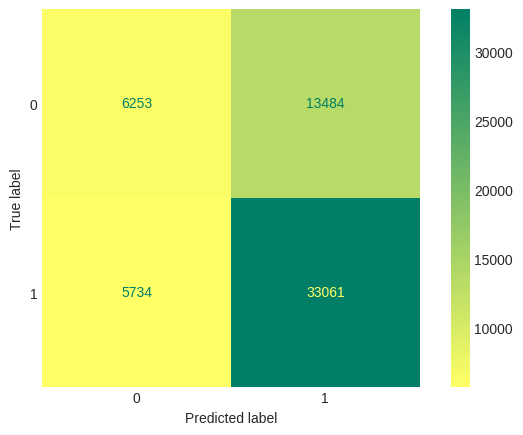

In [60]:
covid_avaliacoes[0] = avaliar_previsoes(y_test, y_pred)

### Modelo 1: SKLearn Random Forest

In [61]:
%%time

rfc = RandomForestClassifier(n_estimators=50, criterion='gini', bootstrap=True, oob_score=True, warm_start=True, random_state=SEMENTE)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

CPU times: user 46.1 s, sys: 894 ms, total: 47 s
Wall time: 47.2 s


              precision    recall  f1-score   support

           0       0.55      0.29      0.38     19737
           1       0.71      0.88      0.78     38795

    accuracy                           0.68     58532
   macro avg       0.63      0.58      0.58     58532
weighted avg       0.65      0.68      0.65     58532



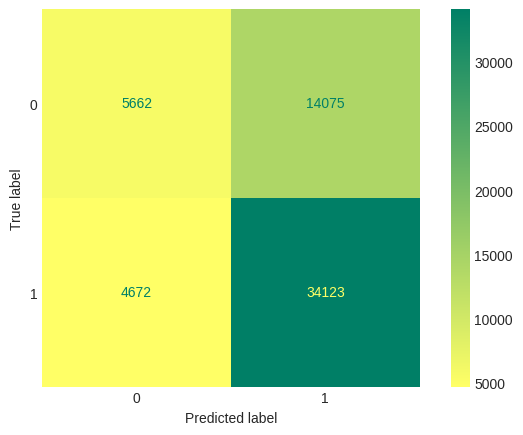

In [62]:
covid_avaliacoes[1] = avaliar_previsoes(y_test, y_pred)

### Modelo 2: SKLearn AdaBoost

In [63]:
%%time

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=SEMENTE)

abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

CPU times: user 22.2 s, sys: 1.56 s, total: 23.8 s
Wall time: 23.9 s


              precision    recall  f1-score   support

           0       0.58      0.23      0.33     19737
           1       0.70      0.92      0.79     38795

    accuracy                           0.68     58532
   macro avg       0.64      0.57      0.56     58532
weighted avg       0.66      0.68      0.64     58532



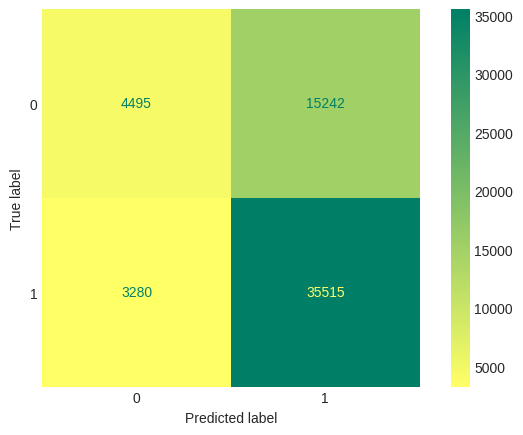

In [64]:
covid_avaliacoes[2] = avaliar_previsoes(y_test, y_pred)

### Modelo 3: SKLearn Gradient Boosting

In [65]:
%%time

gbc = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1.0, criterion='friedman_mse', warm_start=True, max_depth=3, random_state=SEMENTE)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

CPU times: user 37.7 s, sys: 79.2 ms, total: 37.8 s
Wall time: 37.9 s


              precision    recall  f1-score   support

           0       0.59      0.26      0.36     19737
           1       0.71      0.91      0.80     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.58      0.58     58532
weighted avg       0.67      0.69      0.65     58532



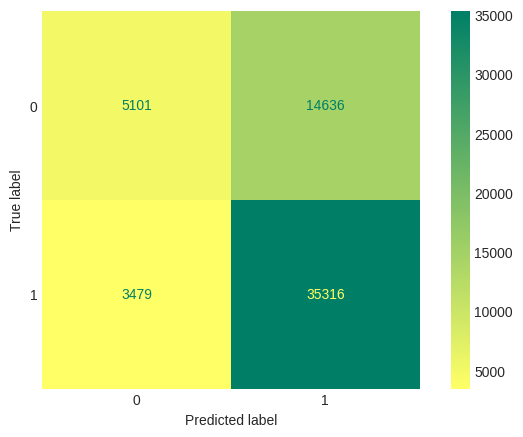

In [66]:
covid_avaliacoes[3] = avaliar_previsoes(y_test, y_pred)

### Modelo 4: XGBoost

In [67]:
%%time

xgb = XGBClassifier(n_estimators=50, grow_policy='depthwise', learning_rate=0.5, random_state=SEMENTE)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

CPU times: user 1min 25s, sys: 411 ms, total: 1min 26s
Wall time: 49.2 s


              precision    recall  f1-score   support

           0       0.60      0.27      0.37     19737
           1       0.71      0.91      0.80     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



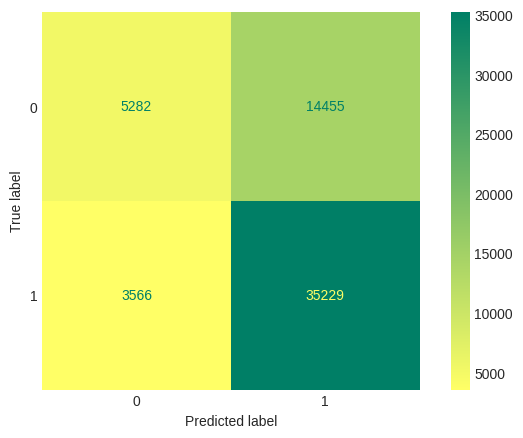

In [68]:
covid_avaliacoes[4] = avaliar_previsoes(y_test, y_pred)

### Modelo 5: TensorFlow Dense

In [69]:
%%time

set_global_determinism(seed=SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
tfd.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfd.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 3min 47s, sys: 2.3 s, total: 3min 49s
Wall time: 3min 14s


              precision    recall  f1-score   support

           0       0.58      0.29      0.38     19737
           1       0.71      0.90      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.59     58532
weighted avg       0.67      0.69      0.66     58532



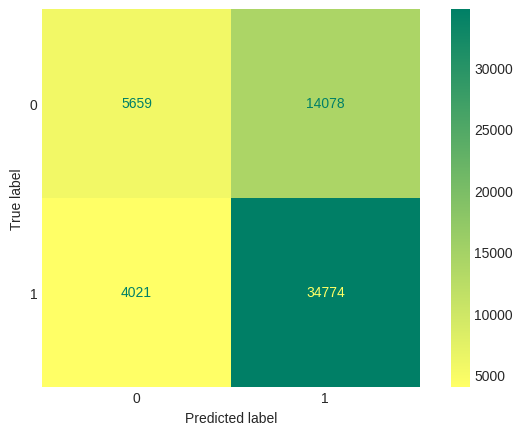

In [70]:
covid_avaliacoes[5] = avaliar_previsoes(y_test, y_pred)

### Modelo 6: TensorFlow Profound

In [71]:
%%time

set_global_determinism(seed=SEMENTE)

tfp = Sequential()

[tfp.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS ** 3)]
tfp.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfp.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfp.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfp.predict(dataset_test, verbose=0))

CPU times: user 15min 29s, sys: 4.18 s, total: 15min 33s
Wall time: 16min 23s


              precision    recall  f1-score   support

           0       0.57      0.30      0.39     19737
           1       0.71      0.88      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.64      0.59      0.59     58532
weighted avg       0.67      0.69      0.66     58532



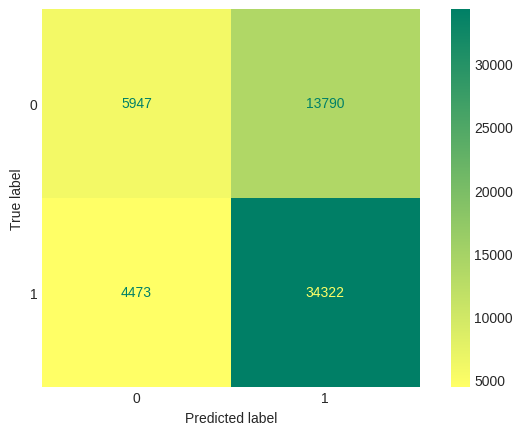

In [72]:
covid_avaliacoes[6] = avaliar_previsoes(y_test, y_pred)

### Modelo 7: TensorFlow Ensemble

In [73]:
%%time

conjunto = obter_conjunto(dados_treino=dataset_train, dados_validacao=dataset_test, q_modelos=5)

Modelo 0 de 5.
Modelo 1 de 5.
Modelo 2 de 5.
Modelo 3 de 5.
Modelo 4 de 5.
CPU times: user 18min 55s, sys: 14.1 s, total: 19min 9s
Wall time: 16min 51s


In [74]:
previsoes = obter_previsoes(conjunto=conjunto, dados_validacao=dataset_test)

y_pred = tf.round(tf.reduce_mean(previsoes, axis=0))

              precision    recall  f1-score   support

           0       0.59      0.29      0.39     19737
           1       0.71      0.90      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.59     58532
weighted avg       0.67      0.69      0.66     58532



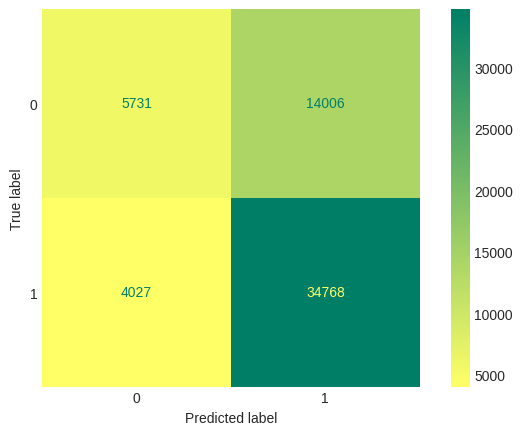

In [75]:
covid_avaliacoes[7] = avaliar_previsoes(y_test, y_pred)

### Comparação de modelos

In [76]:
comparacao = pd.DataFrame([a for a in covid_avaliacoes if a is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

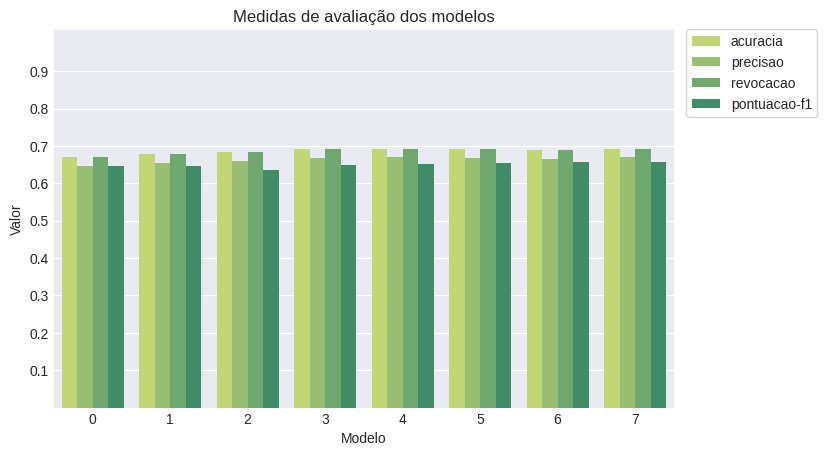

In [77]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette=PALETA)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.ylim(0.0, 1.01)
plt.yticks(np.arange(0.1, 1.0, 0.1))

plt.legend(loc=(1.02, 0.77), frameon=True, facecolor='white');

## Projeção de notificações

Projeção (time series) de notificações por local (detalhamento variável) pelas próximas 8 semanas.

In [6]:
modelos  = [None] * 10
metricas = [None] * 10

modelo_futuro = None

### Hiperparâmetros

In [7]:
LOTE_TAMANHO = 32

CAMADAS = 4

CAMADA_UNIDADES      = 64
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'linear'

PERDA       = 'mae'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['mae', 'mse']

ITERACOES = 500

### Dados

In [8]:
df_populacao  = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_populacao.csv')
df_municipios = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_municipios.csv')
df_unidades   = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_unidades.csv')

df_notificacoes_por_unidade = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_notificacoes_por_unidade.zip', parse_dates=['Segunda-feira'])
df_notificacoes_por_unidade = df_notificacoes_por_unidade[['UF', 'Municipio', 'Unidade', 'Segunda-feira', 'Quantidade']]
df_notificacoes_por_unidade = df_notificacoes_por_unidade.sort_values(by=['UF', 'Municipio', 'Unidade', 'Segunda-feira']).reset_index(drop=True)

df_notificacoes_por_municipio = df_notificacoes_por_unidade[['UF', 'Municipio', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Municipio', 'Segunda-feira']).sum()
df_notificacoes_por_municipio = df_notificacoes_por_municipio.sort_index().reset_index()

df_notificacoes_por_uf = df_notificacoes_por_unidade[['UF', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Segunda-feira']).sum()
df_notificacoes_por_uf = df_notificacoes_por_uf.sort_index().reset_index()

df_notificacoes_por_semana = df_notificacoes_por_unidade[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).sum()
df_notificacoes_por_semana = df_notificacoes_por_semana.sort_index().reset_index()

In [9]:
dados = df_notificacoes_por_semana
q_treino = int(len(dados) * 0.8)

quantidades = dados['Quantidade'].to_numpy().astype('float32')

In [10]:
X_train = dados[:q_treino]['Segunda-feira'].to_numpy()
y_train = dados[:q_treino]['Quantidade'].to_numpy()

X_test = dados[q_treino:]['Segunda-feira'].to_numpy()
y_test = dados[q_treino:]['Quantidade'].to_numpy()

In [11]:
len(quantidades), len(X_train), len(y_train), len(X_test), len(y_test)

(112, 89, 89, 23, 23)

### Modelo 0: Ingênuo

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [12]:
y_pred = y_test[:-1]

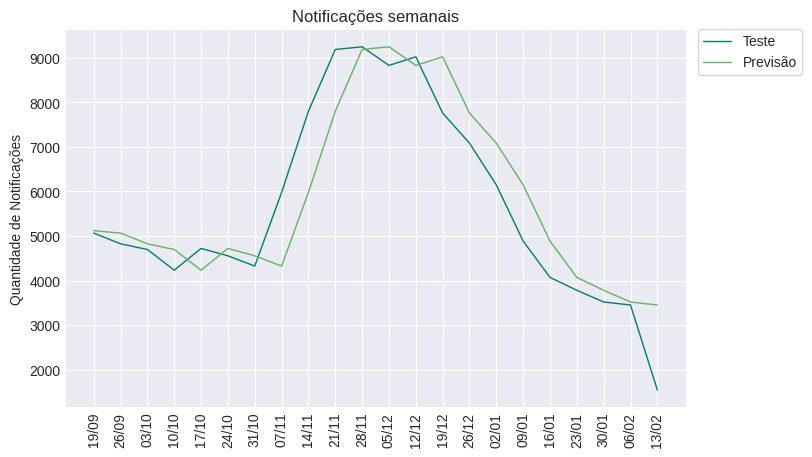

In [13]:
grafico_series(X_teste=X_test[1:], y_teste=y_test[1:],
               X_previsao=X_test[1:], y_previsao=y_pred)

In [14]:
metricas[0] = metricas_modelo(y_test[1:], y_pred)

In [15]:
metricas[0]

{'Mean Absolute Error': 671.7727272727273,
 'Root Mean Squared Error': 898.8617296842207,
 'Mean Absolute Percentage Error': 0.15459536195210424}

### Modelo 1: Denso (7 janelas, 1 horizonte)

In [16]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [17]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_1_denso_7j_1h'

modelos[1] = Sequential(name=modelo_nome)

[modelos[1].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}')) for c in range(CAMADAS)]
modelos[1].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[1].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[1].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[1] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[1].predict(janelas_teste, verbose=0)

CPU times: user 48 s, sys: 836 ms, total: 48.8 s
Wall time: 1min 8s


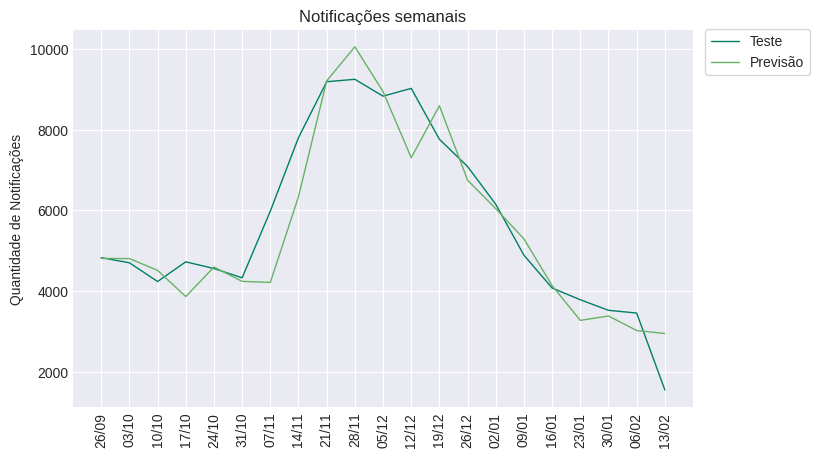

In [18]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

In [19]:
metricas[1] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

In [20]:
metricas[1]

{'Mean Absolute Error': 547.7464,
 'Root Mean Squared Error': 790.82513,
 'Mean Absolute Percentage Error': 0.1217038}

### Modelo 2: Denso (14 janelas, 1 horizonte)

In [21]:
janela_tamanho = 14
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [22]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_2_denso_14j_1h'

modelos[2] = Sequential(name=modelo_nome)

[modelos[2].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}')) for c in range(CAMADAS)]
modelos[2].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[2].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[2].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[2] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[2].predict(janelas_teste, verbose=0)

CPU times: user 48.4 s, sys: 749 ms, total: 49.2 s
Wall time: 1min 23s


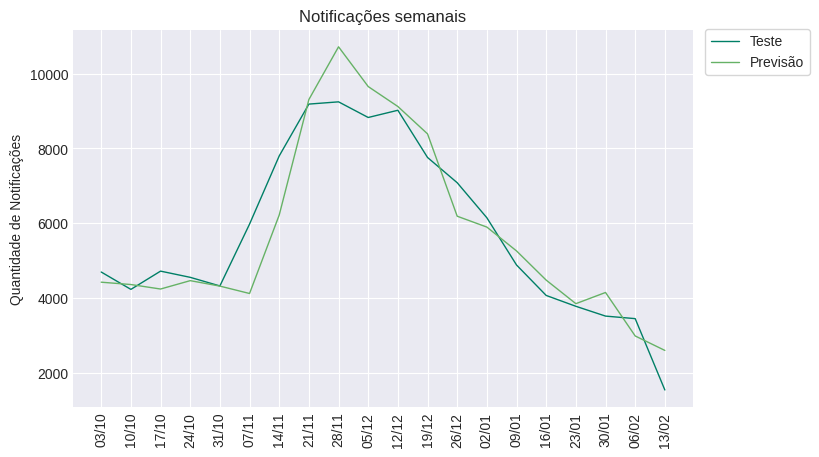

In [23]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

In [24]:
metricas[2] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

In [25]:
metricas[2]

{'Mean Absolute Error': 585.46063,
 'Root Mean Squared Error': 788.74567,
 'Mean Absolute Percentage Error': 0.12214327}

### Modelo 3: Denso (24 janelas, 8 horizontes)

In [26]:
janela_tamanho = 24
horizonte_tamanho = 8

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [27]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_3_denso_24j_8h'

modelos[3] = Sequential(name=modelo_nome)

[modelos[3].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}')) for c in range(CAMADAS)]
modelos[3].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[3].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[3].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[3] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[3].predict(janelas_teste, verbose=0)

CPU times: user 59.6 s, sys: 780 ms, total: 1min
Wall time: 1min 23s


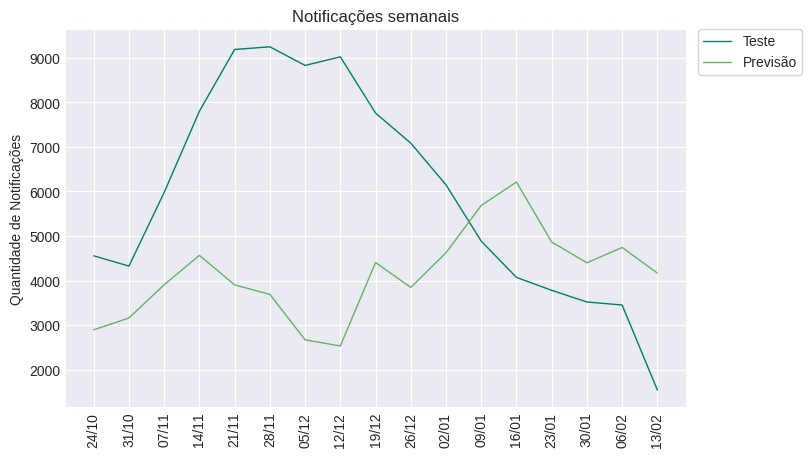

In [28]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

In [29]:
metricas[3] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

In [30]:
metricas[3]

{'Mean Absolute Error': 2856.123,
 'Root Mean Squared Error': 3408.1936,
 'Mean Absolute Percentage Error': 0.49560475}

### Modelo 4: Convulacional

In [31]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

dataset_janelas_treino    = Dataset.from_tensor_slices(janelas_treino)
dataset_janelas_teste     = Dataset.from_tensor_slices(janelas_teste)
dataset_horizontes_treino = Dataset.from_tensor_slices(horizontes_treino)
dataset_horizontes_teste  = Dataset.from_tensor_slices(horizontes_teste)

dataset_treino = Dataset.zip((dataset_janelas_treino, dataset_horizontes_treino))
dataset_teste  = Dataset.zip((dataset_janelas_teste, dataset_horizontes_teste))

dataset_treino = dataset_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_teste  = dataset_teste.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

In [32]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_4_convulacional'

modelos[4] = Sequential(name=modelo_nome)

modelos[4].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão aos dados.

modelos[4].add(Conv1D(filters=CAMADA_UNIDADES,
                      kernel_size=janela_tamanho,
                      kernel_initializer=CAMADA_INICIALIZADOR,
                      padding='causal',
                      activation=CAMADA_ATIVACAO,
                      name='camada_convulacional'))

modelos[4].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[4].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[4].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[4] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[4].predict(janelas_teste, verbose=0)

CPU times: user 1min 11s, sys: 853 ms, total: 1min 12s
Wall time: 1min 23s


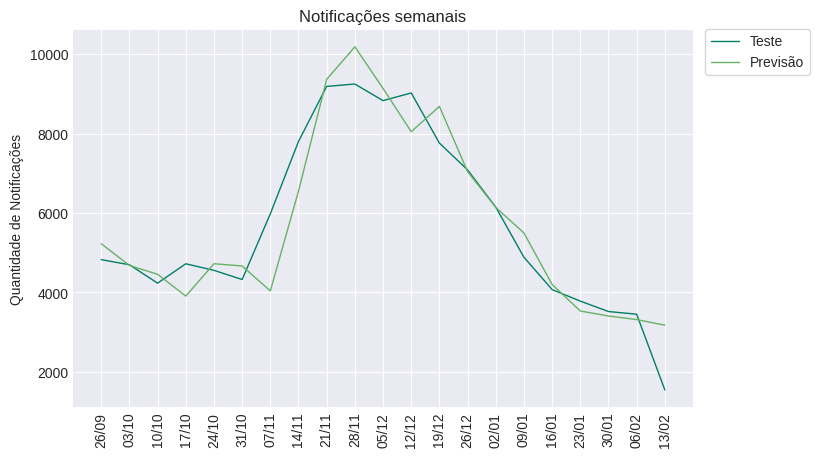

In [33]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

In [34]:
metricas[4] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

In [35]:
metricas[4]

{'Mean Absolute Error': 542.3024,
 'Root Mean Squared Error': 765.0616,
 'Mean Absolute Percentage Error': 0.12627244}

### Modelo 5: N-BEATS

N-BEATS: Neural basis expansion analysis for interpretable time series forecasting https://arxiv.org/abs/1905.10437

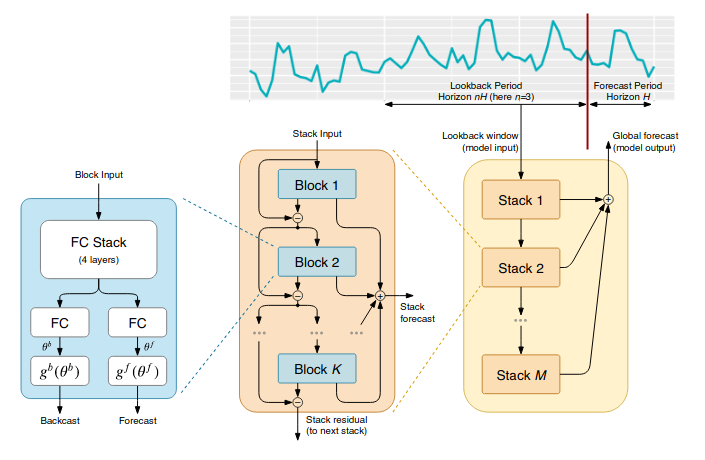

(Do artigo) **Figure 1: Proposed architecture**. The basic building block is a multi-layer Fully Connected (FC) network with ReLU nonlinearities. It predicts basis expansion coefficients both forward, $\theta^f$ (forecast), and backward, $\theta^b$ (backcast). Blocks are organized into stacks using doubly residual stacking principle. A stack may have layers with shared $g^b$ and $g^f$. Forecasts are aggregated in hierarchical fashion. This enables building a very deep neural network with interpretable outputs.


Making new Layers and Models via subclassing https://www.tensorflow.org/guide/keras/custom_layers_and_models

De acordo com o [código fonte](https://github.com/tensorflow/tensorflow/blob/fcc4b966f1265f466e82617020af93670141b009/tensorflow/python/keras/engine/base_layer.py#L308-L316) (em 08.03.2023), os kwargs permitidos pela classe `Layer` são: `input_dim`, `input_shape`, `batch_input_shape`, `batch_size`, `weights`, `activity_regularizer` e `autocast`. Além destes, `Layer` possui os argumentos `trainable`, `name`, `dtype` e `dynamic`.

In [36]:
# A seção 3 do artigo descreve a arquitetura do modelo.
# Para este modelo foi utilizada a arquitetura genérica, descrita na seção 3.3, que não utiliza conhecimentos específicos de séries temporais.

class NBeatsBlock(Layer):

    def __init__(self,
                 input_size: int,
                 horizon: int,
                 n_neurons: int,
                 **kwargs):

        super().__init__(**kwargs)

        self.input_size = input_size  # Tamanho da entrada.
        self.horizon    = horizon     # Tamanho da saída.
        self.n_neurons  = n_neurons   # Quantidade de neurônios.

        self.theta_size = input_size + horizon  # Tamanho do coeficiente de expansão.

        self.hidden      = [Dense(units=n_neurons, activation='relu') for _ in range(4)]  # Camadas densas (FC) ReLU (x4).
        self.theta_layer = Dense(units=self.theta_size, activation='linear')              # Camada theta linear, para backcast e forecast.

    def call(self, inputs):

        x = inputs

        for layer in self.hidden:
            x = layer(x)

        theta = self.theta_layer(x)

        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.horizon:]

        return backcast, forecast

In [37]:
# Hiperparâmetros (Tabela 18)

NBEATS_ITERACOES = 5000
NBEATS_NEURONIOS = 512
NBEATS_PILHAS    = 30
NBEATS_LOTE      = 1024
NBEATS_ENTRADA   = janela_tamanho * horizonte_tamanho
NBEATS_HORIZONTE = horizonte_tamanho

In [38]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

dataset_janelas_treino    = Dataset.from_tensor_slices(janelas_treino)
dataset_janelas_teste     = Dataset.from_tensor_slices(janelas_teste)
dataset_horizontes_treino = Dataset.from_tensor_slices(horizontes_treino)
dataset_horizontes_teste  = Dataset.from_tensor_slices(horizontes_teste)

dataset_treino = Dataset.zip((dataset_janelas_treino, dataset_horizontes_treino))
dataset_teste  = Dataset.zip((dataset_janelas_teste, dataset_horizontes_teste))

dataset_treino = dataset_treino.batch(NBEATS_LOTE).prefetch(AUTOTUNE)
dataset_teste  = dataset_teste.batch(NBEATS_LOTE).prefetch(AUTOTUNE)

In [39]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_5_nbeats'

entradas = Input(shape=(NBEATS_ENTRADA), name='camada_entrada')

residuo, previsao = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                horizon=NBEATS_HORIZONTE,
                                n_neurons=NBEATS_NEURONIOS,
                                name='bloco_0')(entradas)

for p in range(1, NBEATS_PILHAS):

    residuo_pilha, previsao_pilha = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                                horizon=NBEATS_HORIZONTE,
                                                n_neurons=NBEATS_NEURONIOS,
                                                name=f'bloco_{p}')(residuo)

    residuo  = Subtract(name=f"subtracao_{p}")([residuo, residuo_pilha])
    previsao = Add(name=f"adicao_{p}")([previsao, previsao_pilha])

modelos[5] = Model(inputs=entradas, outputs=previsao, name=modelo_nome)

modelos[5].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[5].fit(dataset_treino,
               epochs=NBEATS_ITERACOES,
               validation_data=dataset_teste,
               callbacks=[EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                          ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=0)],
               verbose=0)

previsoes = modelos[5].predict(dataset_teste, verbose=0)

CPU times: user 3min 17s, sys: 2.03 s, total: 3min 19s
Wall time: 3min 58s


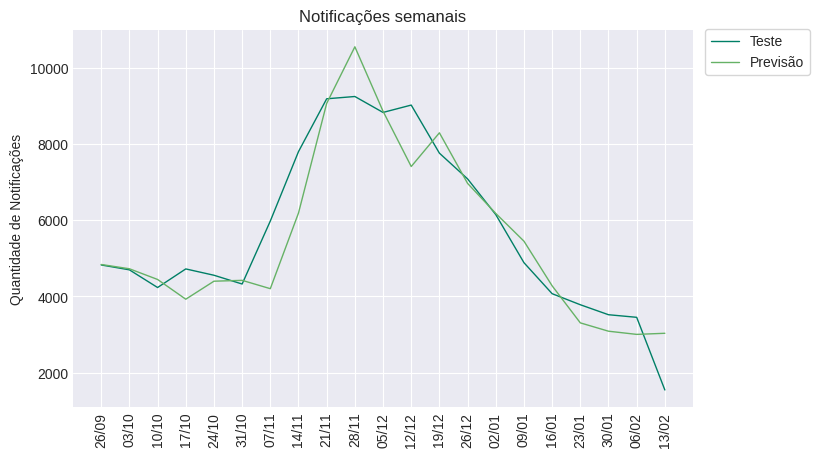

In [40]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

In [41]:
metricas[5] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

In [42]:
metricas[5]

{'Mean Absolute Error': 573.9584,
 'Root Mean Squared Error': 824.2252,
 'Mean Absolute Percentage Error': 0.1296432}

### Comparação dos modelos

In [43]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])
df_metricas.T

,0,1,2,3,4,5
Mean Absolute Error,671.772727,547.746399,585.460632,2856.123047,542.302429,573.958374
Root Mean Squared Error,898.861730,790.825134,788.745667,3408.193604,765.061584,824.225220
Mean Absolute Percentage Error,0.154595,0.121704,0.122143,0.495605,0.126272,0.129643


In [44]:
df_metricas['Mean Absolute Error'].sort_values()

4     542.302429
1     547.746399
5     573.958374
2     585.460632
0     671.772727
3    2856.123047
Name: Mean Absolute Error, dtype: float64

### Modelo futuro

In [45]:
janela_tamanho = 7
horizonte_tamanho = 1
quantidade_intervalos = 8

# quantidades = df_notificacoes_por_uf[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).mean()
# quantidades = quantidades.sort_index().reset_index()['Quantidade'].to_numpy().astype('float32')

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

dataset_janelas    = Dataset.from_tensor_slices(janelas)
dataset_horizontes = Dataset.from_tensor_slices(horizontes)

dataset_completo = Dataset.zip((dataset_janelas, dataset_horizontes))
dataset_completo = dataset_completo.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

In [46]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_futuro'

modelo_futuro = Sequential(name=modelo_nome)

modelo_futuro.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))

modelo_futuro.add(Conv1D(filters=CAMADA_UNIDADES,
                         kernel_size=janela_tamanho,
                         kernel_initializer=CAMADA_INICIALIZADOR,
                         padding='causal',
                         activation=CAMADA_ATIVACAO,
                         name='camada_convulacional'))

modelo_futuro.add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelo_futuro.compile(loss=PERDA,
                      optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                      metrics=METRICAS)

modelo_futuro.fit(dataset_completo, epochs=ITERACOES, verbose=0)

CPU times: user 7.37 s, sys: 286 ms, total: 7.65 s
Wall time: 10.1 s


In [47]:
# previsoes = gerar_previsoes_futuro(modelo_futuro, quantidades, quantidade_intervalos, janela_tamanho)

# df_futuro = pd.DataFrame(pd.date_range(X_test.max(), periods=(quantidade_intervalos + 1), freq='W-MON', closed='right').to_numpy(), columns=['Segunda-feira'])
# df_futuro['Quantidade'] = previsoes

# display(df_futuro)

# grafico_series(X_previsao=df_futuro['Segunda-feira'], y_previsao=df_futuro['Quantidade'])

#### Testes

In [48]:
# uf_cod  = 'MG'
# uf_desc = df_populacao['Nome'][df_populacao['UF'] == uf_cod].values[0]

# dados = df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod]
# local = f"{uf_cod} - {uf_desc}"

In [49]:
lo = random.randint(0, 2)
dados = []
local = ''

while(len(dados) <= 16):
    if(lo == 0):
        uf_cod, uf_desc = df_populacao[['UF', 'Nome']].sample().values[0]
        dados = df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod]
        local = f" {uf_cod} - {uf_desc}"
    elif(lo == 1):
        mu_cod, mu_desc = df_municipios[['Codigo', 'Municipio']].sample().values[0]
        dados = df_notificacoes_por_municipio[df_notificacoes_por_municipio['Municipio'] == mu_cod]

        if len(dados) > 0:
            local = f"\n{mu_cod} - {mu_desc} ({dados['UF'].values[0]})"
    else:
        un_cod, un_desc = df_unidades[['Codigo', 'Unidade']].sample().values[0]
        dados = df_notificacoes_por_unidade[df_notificacoes_por_unidade['Unidade'] == un_cod]

        if len(dados) > 0:
            mu_cod, mu_desc = df_municipios[['Codigo', 'Municipio']][df_municipios['Codigo'] == dados['Municipio'].values[0]].values[0]
            local = f"\n{mu_cod} - {mu_desc} ({dados['UF'].values[0]})\nUnidade {un_cod} - {un_desc}"

In [50]:
X_train = dados[:-quantidade_intervalos]['Segunda-feira'].to_numpy()
y_train = dados[:-quantidade_intervalos]['Quantidade'].to_numpy()

X_test = dados[-quantidade_intervalos:]['Segunda-feira'].to_numpy()
y_test = dados[-quantidade_intervalos:]['Quantidade'].to_numpy()

y_pred = gerar_previsoes_futuro(modelo_futuro, y_train, quantidade_intervalos, janela_tamanho)

# Inclui o último valor de treino no teste e na previsão, para o gráfico não parecer quebrado.
X_test = np.insert(X_test, 0, X_train[-1])
y_test = np.insert(y_test, 0, y_train[-1])
y_pred = np.insert(y_pred, 0, y_train[-1])

In [51]:
# modelo_futuro, y_train, quantidade_intervalos, janela_tamanho, dados

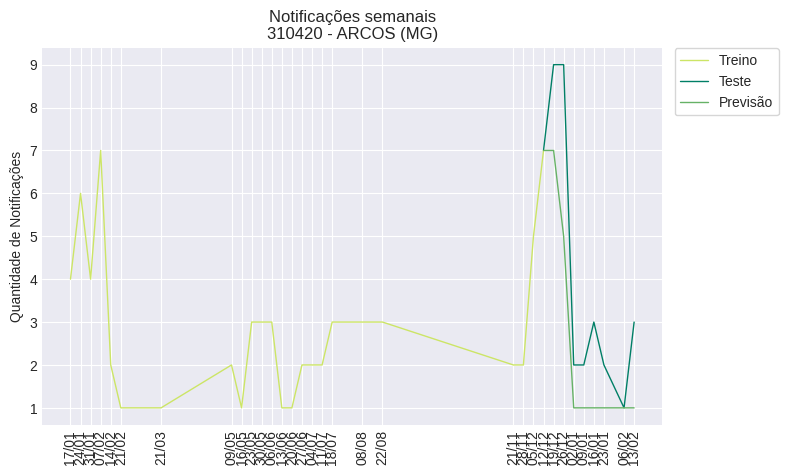

In [52]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test,
               X_previsao=X_test, y_previsao=y_pred,
               inicio=-24, local=local)